<a href="https://colab.research.google.com/github/NHCh1/DLI/blob/main/DLI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/NHCh1/DLI/refs/heads/main/Dli-mendeley_18.csv'
data = pd.read_csv(url, header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,3,1,5,72,0,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,3,1,3,144,0,0,0,0,2,0,...,0,0,0,1,-1,1,1,1,1,1
2,3,1,2,58,0,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,3,1,6,79,1,0,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,3,0,4,46,0,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,1,1,50,0,0,0,0,0,0,...,0,0,0,1,1,-1,1,0,1,0
9996,2,1,4,59,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
9997,2,1,4,57,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
9998,3,1,1,49,0,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0


In [2]:
#Array of features
x = data.drop([48], axis=1)
print(x)

#Array of target
y = data[48]
print(y)

      0   1   2    3   4   5   6   7   8   9   ...  38  39  40  41  42  43  \
0      3   1   5   72   0   0   0   0   0   0  ...   0   0   0   1   1   0   
1      3   1   3  144   0   0   0   0   2   0  ...   0   0   0   0   1  -1   
2      3   1   2   58   0   0   0   0   0   0  ...   0   0   0   0   1   0   
3      3   1   6   79   1   0   0   0   0   0  ...   1   0   0   0   1  -1   
4      3   0   4   46   0   0   0   0   0   0  ...   0   1   0   0   1   1   
...   ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
9995   3   1   1   50   0   0   0   0   0   0  ...   0   0   0   0   1   1   
9996   2   1   4   59   1   0   0   0   0   0  ...   0   1   0   0   1   0   
9997   2   1   4   57   0   0   0   0   0   0  ...   0   0   0   0   1   0   
9998   3   1   1   49   0   0   0   0   0   0  ...   0   1   0   0   1   1   
9999   3   1   2   52   3   0   0   0   0   0  ...   0   0   0   0   1   1   

      44  45  46  47  
0      1   1  -1   1  
1      1   1   1 

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)


In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

print(x_train)
print('------------------------------------------------------------------')
print(x_test)

[[ 0.4264587  -0.76932106 -0.15488093 ...  0.39933321 -0.23638944
   0.76186885]
 [-1.06951269 -0.76932106 -0.69750681 ...  0.39933321  1.0884513
   0.76186885]
 [ 1.92243009  0.5460789   0.93037084 ...  0.39933321 -0.23638944
   0.76186885]
 ...
 [-0.32152699  0.5460789  -0.15488093 ...  0.39933321  1.0884513
  -1.47048024]
 [-0.32152699  0.5460789   0.93037084 ...  0.39933321 -0.23638944
   0.76186885]
 [-0.32152699 -0.76932106  0.38774495 ...  0.39933321  1.0884513
   0.76186885]]
------------------------------------------------------------------
[[-0.32152699  0.5460789  -0.15488093 ...  0.39933321  1.0884513
   0.76186885]
 [ 9.40228702  0.5460789   0.38774495 ...  0.39933321 -0.23638944
   0.76186885]
 [-0.32152699 -0.76932106  2.0156226  ...  0.39933321 -0.23638944
   0.76186885]
 ...
 [ 0.4264587   0.5460789  -1.2401327  ... -1.51922032 -1.56123018
  -0.35430569]
 [-1.06951269 -0.76932106 -1.78275858 ...  0.39933321 -0.23638944
  -0.35430569]
 [-0.32152699  0.5460789  -0.154880

In [5]:
# MODEL - XGBOOST
from xgboost import XGBClassifier
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(x_train, y_train)

xgb_train_pred = xgb_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
xgb_test_pred = xgb_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

from sklearn.metrics import roc_auc_score
xgb_accuracy = roc_auc_score(y_test, xgb_test_pred)
print(f"XGBoosting Accuracy: {xgb_accuracy:.4f}")

XGBoosting Accuracy: 0.9979


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

# reshape input from 2D to 3D
x_train_cnn = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_cnn = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# MODEL - CNN_COMPLEX
def cnn_complex_tabular():
    model = Sequential()
    model.add(Input(shape=(48, 1)))
    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 7, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# Train CNN
cnn_model = cnn_complex_tabular()
cnn_model.fit(x_train_cnn, y_train, epochs=25, batch_size=1000, verbose=0)

cnn_train_pred = cnn_model.predict(x_train_cnn)
cnn_test_pred = cnn_model.predict(x_test_cnn)

cnn_accuracy = roc_auc_score(y_test, cnn_test_pred)
print(f"ConvolutionalNN Accuracy: {cnn_accuracy:.4f}")

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
ConvolutionalNN Accuracy: 0.9944


In [7]:
# MODEL - GRADIENT BOOSTING
from sklearn.ensemble import GradientBoostingClassifier
gbc_model = GradientBoostingClassifier(max_depth=4, learning_rate=0.7)
gbc_model.fit(x_train, y_train)

gbc_train_pred = gbc_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
gbc_test_pred = gbc_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

gbc_accuracy = roc_auc_score(y_test, gbc_test_pred)
print(f"GradientBoosting Accuracy: {gbc_accuracy:.4f}")

GradientBoosting Accuracy: 0.9960


In [8]:
# MODEL - DECISION TREE
from sklearn.tree import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier(max_depth=12)
dtc_model.fit(x_train, y_train)

dtc_train_pred = dtc_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
dtc_test_pred = dtc_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

dtc_accuracy = roc_auc_score(y_test, dtc_test_pred)
print(f"DecisionTree Accuracy: {dtc_accuracy:.4f}")

DecisionTree Accuracy: 0.9561


In [9]:
# MODEL - STACKING
import numpy as np
stacked_train = np.hstack([xgb_train_pred, cnn_train_pred, gbc_train_pred, dtc_train_pred])
stacked_test = np.hstack([xgb_test_pred, cnn_test_pred, gbc_test_pred, dtc_test_pred])

from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()
meta_model.fit(stacked_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = meta_model.predict(stacked_test)
acc = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy: {acc:.4f}")

Stacked Model Accuracy: 0.9843


In [10]:
# FEATURE SELECTION - XGBOOST

from sklearn.feature_selection import RFECV
selector = RFECV(xgb_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
xgb_col = np.where(selector.ranking_==1)
print(xgb_col)

from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline

pipe_xgb = make_pipeline(ColumnSelector(cols=(0,  1,  2,  3,  4,  5,  8,  9, 10, 11, 13, 14, 15, 18, 20, 21, 22,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 45, 46,
       47)),xgb_model)

pipe_xgb.fit(x_train, y_train)
pipe_xgb_train = pipe_xgb.predict_proba(x_train)[:, 1].reshape(-1, 1)
pipe_xgb_test = pipe_xgb.predict_proba(x_test)[:, 1].reshape(-1, 1)
pipe_xgb_accuracy = roc_auc_score(y_test, pipe_xgb_test)
print(f"Pipe Xgb Accuracy: {pipe_xgb_accuracy:.4f}")

(array([ 0,  1,  2,  3,  4,  5,  8,  9, 10, 11, 13, 14, 15, 18, 20, 21, 22,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 45, 46,
       47]),)
Pipe Xgb Accuracy: 0.9981


In [11]:
# FEATURE SELECTION - CNN_COMPLEX

from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(score_func=mutual_info_classif, k=30)
x_selected = selector.fit_transform(x, y)
cnn_cols = selector.get_support(indices=True)
print(cnn_cols)

cnn_x_train = x_train[:, cnn_cols].reshape(-1, len(cnn_cols), 1)
cnn_x_test = x_test[:, cnn_cols].reshape(-1, len(cnn_cols), 1)

pipe_cnn = cnn_complex_tabular()
pipe_cnn.fit(cnn_x_train, y_train, epochs=25, batch_size=1000, verbose=0)
pipe_cnn_train = pipe_cnn.predict(cnn_x_train)
pipe_cnn_test = pipe_cnn.predict(cnn_x_test)
pipe_cnn_accuracy = roc_auc_score(y_test, pipe_cnn_test)
print(f"Pipe Cnn Accuracy: {pipe_cnn_accuracy:.4f}")

[ 0  1  2  3  4  5  8 10 11 13 16 20 21 22 24 26 27 28 29 30 33 34 38 39
 42 43 44 45 46 47]
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Pipe Cnn Accuracy: 0.9931


In [12]:
# FEATURE SELECTION - GRADIENT BOOSTING

selector = RFECV(gbc_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
gbc_col = np.where(selector.ranking_==1)
print(gbc_col)

pipe_gbc = make_pipeline(ColumnSelector(cols=(0,  1,  2,  3,  4,  5,  8,  9, 10, 11, 13, 14, 16, 20, 21, 22, 24,
       26, 27, 28, 29, 31, 33, 34, 38, 39, 40, 46, 47)),gbc_model)

pipe_gbc.fit(x_train, y_train)
pipe_gbc_train = pipe_gbc.predict_proba(x_train)[:, 1].reshape(-1, 1)
pipe_gbc_test = pipe_gbc.predict_proba(x_test)[:, 1].reshape(-1, 1)
pipe_gbc_accuracy = roc_auc_score(y_test, pipe_gbc_test)
print(f"Pipe Gbc Accuracy: {pipe_gbc_accuracy:.4f}")

(array([ 0,  1,  2,  3,  4,  5,  8,  9, 10, 11, 13, 14, 16, 20, 21, 22, 24,
       26, 27, 28, 29, 31, 33, 34, 38, 39, 40, 46, 47]),)
Pipe Gbc Accuracy: 0.9974


In [13]:
# FEATURE SELECTION - DECISION TREE

selector = RFECV(dtc_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
dtc_col = np.where(selector.ranking_==1)
print(dtc_col)

pipe_dtc = make_pipeline(ColumnSelector(cols=(0,  2,  3,  4,  8,  9, 13, 14, 20, 21, 22, 24, 26, 27, 29, 33, 34, 38, 39, 45, 47)),dtc_model)

pipe_dtc.fit(x_train, y_train)
pipe_dtc_train = pipe_dtc.predict_proba(x_train)[:, 1].reshape(-1, 1)
pipe_dtc_test = pipe_dtc.predict_proba(x_test)[:, 1].reshape(-1, 1)
pipe_dtc_accuracy = roc_auc_score(y_test, pipe_dtc_test)
print(f"Pipe Dtc Accuracy: {pipe_dtc_accuracy:.4f}")

(array([ 0,  2,  3,  4,  8,  9, 11, 13, 14, 20, 21, 22, 24, 26, 27, 29, 31,
       33, 34, 38, 39, 45, 47]),)
Pipe Dtc Accuracy: 0.9636


In [14]:
# FEATURE SELECTION - STACKING

pipe_st_train = np.hstack([pipe_xgb_train, pipe_cnn_train, pipe_gbc_train, pipe_dtc_train])
pipe_st_test = np.hstack([pipe_xgb_test, pipe_cnn_test, pipe_gbc_test, pipe_dtc_test])

pipe_model = LogisticRegression()
pipe_model.fit(pipe_st_train, y_train)

y_pred_pipe = pipe_model.predict(pipe_st_test)
acc = accuracy_score(y_test, y_pred_pipe)
print(f"Stacked Model with Features Accuracy: {acc:.4f}")

Stacked Model with Features Accuracy: 0.9840


In [15]:
# Create a dictionary from the actual test result and predicted result
comparison = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})

true_positive = ((comparison['y_pred'] == 0) & (comparison['y_test'] == 0)).sum()
print(f"True Positive: {true_positive}")

true_negative = ((comparison['y_pred'] == 1) & (comparison['y_test'] == 1)).sum()
print(f"True Negative: {true_negative}")

false_positive = ((comparison['y_pred'] == 0) & (comparison['y_test'] == 1)).sum()
print(f"False Positive: {false_positive}")

false_negative = ((comparison['y_pred'] == 1) & (comparison['y_test'] == 0)).sum()
print(f"False Negative: {false_negative}")

accuracy = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
print(f"Accuracy: {accuracy:.8f}")

True Positive: 1461
True Negative: 1492
False Positive: 19
False Negative: 28
Accuracy: 0.98433333


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1489
           1       0.98      0.99      0.98      1511

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



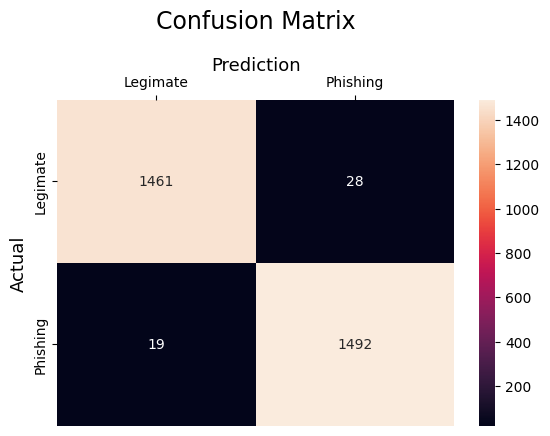

In [16]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

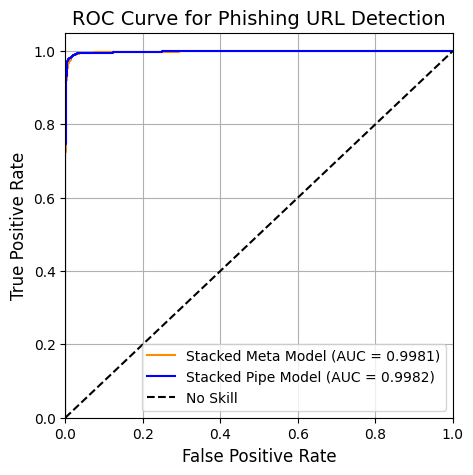

In [17]:
# Receiver Operating Characteristic Curve
from sklearn.metrics import roc_curve, auc

y_prob_meta = meta_model.predict_proba(stacked_test)[:, 1]
y_prob_pipe = pipe_model.predict_proba(pipe_st_test)[:, 1]
fpr_meta, tpr_meta, thresholds_meta = roc_curve(y_test, y_prob_meta)
fpr_pipe, tpr_pipe, thresholds_pipe = roc_curve(y_test, y_prob_pipe)
roc_auc_meta = auc(fpr_meta, tpr_meta)
roc_auc_pipe = auc(fpr_pipe, tpr_pipe)

plt.figure(figsize=(5, 5))
plt.plot(fpr_meta, tpr_meta, label='Stacked Meta Model (AUC = %0.4f)' % roc_auc_meta, color='darkorange')
plt.plot(fpr_pipe, tpr_pipe, label='Stacked Pipe Model (AUC = %0.4f)' % roc_auc_pipe, color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Phishing URL Detection', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()